### ZNE Run
 - Circuit Used - QuantumVolume circuit
 - Qubits Tested - [3,5,7,9,10]
 - Test-Cases - No_ZNE and With_ZNE
 - Circuit Transpilation - Default transpiled with Optimization level = 3

In [1]:
import sys
import os

# Add project root (one level up from 'notebooks')
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [2]:
# kurianuthuppu11@gmail.com

token = "VybxF62Uoej4Tv3RvtlSBDeBOAryDKX97yJvsqL2gAB_"

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    token=token,
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/e3a7616824024c57b40a7014c5e27c30:b4f5e1cd-3aba-470f-93e5-f82079969538::",
    channel="ibm_quantum_platform",
    overwrite=True,
    set_as_default=True,
    name="qamp-2025",
)

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    EstimatorV2 as Estimator,
    EstimatorOptions,
    Batch,
)
from qiskit.quantum_info import SparsePauliOp
import qiskit.circuit.library.quantum_volume as QuantumVolume
from qiskit_aer.primitives import EstimatorV2 as AerEstimator, SamplerV2 as AerSampler
from qiskit.primitives import StatevectorEstimator as SVEstimator
from adaptive_error_mitigation.analytics import (
    extract_basic_features,
    extract_backend_metrics,
    get_qubit_layout_mapping,
    analyze_qubit_idling,
    calculate_derived_noise_metrics,
)
from qiskit.providers.backend import BackendV2 as Backend
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

In [4]:
def prepare_quant_vol(n_qubits: int, seed: int=42):
    ## Prepares standard ghz state with measurements on all qubits using measure_all()
    circuit = QuantumVolume(num_qubits=n_qubits, seed=seed)
    return circuit


def naked_estimator(mode):
    ## Estimator with no error mitigation or supression for any mode (job, batch). ALL OPTIONS ARE DISABLED.
    config_est_options = {
        "dynamical_decoupling": {"enable": False},
        "twirling": {"enable_gates": False, "enable_measure": False},
        "resilience_level": 0,
        "resilience": {
            "zne_mitigation": False,
        },
    }

    estimator_options = EstimatorOptions(**config_est_options)
    estimator = Estimator(mode=mode, options=estimator_options)
    return estimator

def zne_gt_estimator(mode):
## Estimator with no error mitigation or supression for any mode (job, batch). ALL OPTIONS ARE DISABLED.
    config_est_options = {
        "dynamical_decoupling": {"enable": False},
        "twirling": {"enable_gates": True, "enable_measure": False},
        "resilience_level": 0,
        "resilience": {
            "zne_mitigation": True,
            "zne": {
                "amplifier": "gate_folding",
                "noise_factors": (1, 3, 5),
                "extrapolator": "exponential",
            },
        },
    }

    estimator_options = EstimatorOptions(**config_est_options)
    estimator = Estimator(mode=mode, options=estimator_options)
    return estimator


def pm_for_backend(bknd, opt_level=3, seed=42069):
    ## Returns a PassManager from generate_preset_pass_manager for given opt_level and backend(bknd)
    pm = generate_preset_pass_manager(
        optimization_level=opt_level,
        backend=bknd,
        seed_transpiler=seed,
    )
    return pm


def create_isa_observables(isa_circuit_dict, pauli_char="Z"):
    ## Returns a dict of ISA observables with layouts applied, matching the input isa_circuit_dict keys.
    isa_observables = {}

    for key, isa_qc in isa_circuit_dict.items():
        # 1. Parse qubit count from key
        num_qubits = int(key)

        # 2. Create the logical observable (e.g., "ZZZ")
        observable = SparsePauliOp(pauli_char * num_qubits)

        # 3. Apply the layout from the transpiled circuit
        isa_obs = observable.apply_layout(isa_qc.layout)

        isa_observables[key] = isa_obs

    return isa_observables


def transpile_for_dd(circuit, dd_pm):
    isa_dd_circuit = dd_pm.run(circuit)
    return isa_dd_circuit


def get_h_zne(qc, backend):
    # 1. Extract required metrics using your helper functions
    qubits_used = extract_basic_features(qc)["qubits_used"]
    ons = calculate_derived_noise_metrics(qc, backend)["overall_noise_sensitivity"]
    t2_avg = extract_backend_metrics(qc, backend)["avg_t2_time"]

    # 2. Get circuit duration from the backend target
    duration_ns = qc.estimate_duration(backend.target)

    # 3. Calculate H_ZNE (Handling division by zero)
    if t2_avg == 0:
        return 0.0

    h_zne = ons + qubits_used * (duration_ns / t2_avg)
    return h_zne

In [5]:
# Backend
service = QiskitRuntimeService(name="qamp-2025")
bknd_fez = service.backend("ibm_fez")

management.get:WARNING:2025-12-27 10:56:31,149: Loading saved account: qamp-2025


In [15]:
## Simulate on Aer Simulator
aer_estimator = AerEstimator()
QUBIT_SET = [8]

for i in QUBIT_SET:
    for j in range(25):
        seed = np.random.randint(0, 100000)
        crkt = prepare_quant_vol(i, seed)
        pm3 = pm_for_backend(bknd_fez)
        isa_qc = pm3.run(crkt)
        # 2. Create the logical observable (e.g., "ZZZ")
        observable = SparsePauliOp("Z" * i)

        # 3. Apply the layout from the transpiled circuit
        isa_obs = observable.apply_layout(isa_qc.layout)

        aer_job = aer_estimator.run([(isa_qc, isa_obs)])
        aer_result = aer_job.result()
        evs = aer_result[0].data.evs
        if evs > 0.2 or evs < -0.2:
            break

    print(f"Num_Qubit: {i} | Seed:{seed} | Exp. Val:{evs}")

Num_Qubit: 8 | Seed:19634 | Exp. Val:0.12192698056165598


In [16]:
QUBIT_SEED = [
    (2, 43574),
    (4, 86134),
    (6, 7970),
    (8, 19634),
]

In [17]:
## Prepare circuit dict
circuit_dict = {
    f"{n_qubits}": prepare_quant_vol(n_qubits, seed) for n_qubits, seed in QUBIT_SEED
}
circuit_dict

{'2': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x20ed13c56d0>,
 '4': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x20ed12faf50>,
 '6': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x20ed12fb6d0>,
 '8': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x20ed12fbf90>}

In [18]:
## Transpiler with optimization_level=3
pm3 = pm_for_backend(bknd_fez)
isa_dict = {f"{i}": pm3.run(circuit_dict[f"{i}"]) for i, _ in QUBIT_SEED}

In [19]:
obs_isa_dict = create_isa_observables(isa_dict, pauli_char="Z")

In [97]:
# isa_dict["5"].draw("mpl", fold=-1)

In [20]:
crkt_depth_dict = {
    f"{key}": extract_basic_features(isa_qc)["depth"]
    for key, isa_qc in isa_dict.items()
}
crkt_depth_dict

{'2': 19, '4': 157, '6': 183, '8': 287}

In [21]:
cnt_1q_dict = {
    f"{key}": extract_basic_features(isa_qc)["num_1q_gates"]
    for key, isa_qc in isa_dict.items()
}
cnt_1q_dict

{'2': 29, '4': 219, '6': 434, '8': 825}

In [22]:
cnt_2q_dict = {
    f"{key}": extract_basic_features(isa_qc)["num_2q_gates"]
    for key, isa_qc in isa_dict.items()
}
cnt_2q_dict

{'2': 3, '4': 36, '6': 72, '8': 150}

In [23]:
h_zne_dict = {
    f"{key}": get_h_zne(isa_qc, bknd_fez)
    for key, isa_qc in isa_dict.items()
}
h_zne_dict

{'2': 0.010451210995737937,
 '4': 0.18308320505191134,
 '6': 0.36852253311886074,
 '8': 0.7865335608260617}

In [24]:
## Simulate on Aer Simulator
aer_estimator = AerEstimator()

aer_pub = [(isa_dict[f"{i}"], obs_isa_dict[f"{i}"]) for i, _ in QUBIT_SEED]

for i in QUBIT_SET:
    aer_job = aer_estimator.run(aer_pub)
    aer_result = aer_job.result()

ideal_est = {f"{QUBIT_SEED[i][0]}": aer_result[i].data.evs for i in range(len(QUBIT_SEED))}
ideal_est

{'2': array(0.23208538),
 '4': array(-0.39539232),
 '6': array(-0.22130419),
 '8': array(0.12192698)}

In [25]:
## PUB for experiment. Each pub has circuit(num_qubits 'q') and contains two circuits [(isa_dict['q']), (isa_dd_dict['q'])]

pub_hardware_dict = {
    f"{i}": [(isa_dict[f"{i}"])]
    for i, _ in QUBIT_SEED
}
pub_hardware_dict

{'2': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x20ed13b4f90>],
 '4': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x20ed13dbb50>],
 '6': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x20ed1399f90>],
 '8': [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x20ed132cc10>]}

In [26]:
# --- 1. PREPARATION ---
all_pubs = []
result_map = []

# Iterate through your hardware dictionary
for qubit_count, circuit_list in pub_hardware_dict.items():

    # Get the observable for this specific qubit count
    # (We assume obs_isa_dict has keys like '5', '11', etc.)
    current_obs = obs_isa_dict[qubit_count]

    for i, circ in enumerate(circuit_list):
        # Safety: Sanitize Name
        circ.name = f"{qubit_count}q_isa_only"

        # Create PUB: (Circuit, Observable)
        pub = (circ, current_obs)
        all_pubs.append(pub)

        # Store metadata
        # Since you have no DD methods, we hardcode 'method' to 'Standard'
        result_map.append({"qubits": qubit_count, "method": "Standard_ISA"})

print(f"Total PUBs per job: {len(all_pubs)}")

Total PUBs per job: 4


In [27]:
# Store job objects to retrieve results later
batch_jobs = []
NUM_ITRS = 3

# Open the Batch Context
with Batch(backend=bknd_fez) as batch:
    # Initialize Estimator with the batch context
    nake_est = naked_estimator(mode=batch)
    zne_gt_est =zne_gt_estimator(mode=batch)

    # 3. Loop for the iterations
    for i in range(NUM_ITRS):

        # Submit ALL pubs in ONE job
        # Note: all_pubs is already a list of (circuit, observable) tuples
        job = nake_est.run(all_pubs)
        id = job.job_id()
        print(f"Submitted Job-ID for iteration {i+1}/{NUM_ITRS}...: {id}")
        batch_jobs.append(job)

        job = zne_gt_est.run(all_pubs)
        id = job.job_id()
        print(f"Submitted Job-ID for iteration {i+1}/{NUM_ITRS}...: {id}")
        batch_jobs.append(job)

print("All jobs submitted. Waiting for results...")

Submitted Job-ID for iteration 1/3...: d57mu3fp3tbc73aqedug
Submitted Job-ID for iteration 1/3...: d57mu3onsj9s73b4u430
Submitted Job-ID for iteration 2/3...: d57mu47p3tbc73aqedvg
Submitted Job-ID for iteration 2/3...: d57mu4fp3tbc73aqee0g
Submitted Job-ID for iteration 3/3...: d57mu4jht8fs73a306fg
Submitted Job-ID for iteration 3/3...: d57mu4onsj9s73b4u44g
All jobs submitted. Waiting for results...


In [ ]:
# batch_jobs = []
# jobs = [
#     "d57mu3fp3tbc73aqedug",
#     "d57mu3onsj9s73b4u430",
#     "d57mu47p3tbc73aqedvg",
#     "d57mu4fp3tbc73aqee0g",
#     "d57mu4jht8fs73a306fg",
#     "d57mu4onsj9s73b4u44g",
# ]
# for job_id in jobs:
#     job = service.job(job_id=job_id)
#     batch_jobs.append(job)

In [28]:
import pandas as pd

# --- 3. ANALYSIS ---
plot_data = []

print(f"Processing {len(batch_jobs)} jobs...")

for global_idx, job in enumerate(batch_jobs):

    # --- LOGIC: EVEN = Naked, ODD = ZNE ---
    is_zne = global_idx % 2 != 0
    mitigation_type = "With_ZNE_GT" if is_zne else "No_ZNE"

    # Calculate Iteration Number (e.g., Job 0&1 = Itr 1, Job 2&3 = Itr 2)
    iteration_num = (global_idx // 2) + 1

    try:
        # Get results (blocks until ready)
        pub_results = job.result()
        current_job_id = job.job_id()
    except Exception as e:
        print(f"Job {job.job_id()} failed: {e}")
        continue

    # Process each qubit result within the job
    for i, pub_result in enumerate(pub_results):
        meta = result_map[i]

        q_count = meta["qubits"]
        q_str = str(q_count)  # Ensure key is string for dict lookups

        # 1. Get Values
        ev_exp = float(pub_result.data.evs)
        ev_ideal = float(ideal_est[q_str])  # Uses your ideal dictionary

        # 2. Calculate Error
        abs_error = abs(ev_exp - ev_ideal)

        # 3. Retrieve Physics Metrics (Safety .get used in case key is missing)
        # Note: Ensure cd_isa_qc_dict and max_dec_isa_qc_dict exist from previous steps
        crkt_depth = crkt_depth_dict.get(q_str, 0)
        cnt_1q = cnt_1q_dict.get(q_str, 0)
        cnt_2q = cnt_2q_dict.get(q_str, 0)
        h_zne = h_zne_dict.get(q_str,0)

        # 4. Create Label
        label = f"{q_str}q ({mitigation_type})"

        plot_data.append(
            {
                "Label": label,
                "Qubits": int(q_count),
                "Iteration": iteration_num,
                "Mitigation": mitigation_type,
                "Abs_Error": abs_error,
                "Exp_Value": ev_exp,
                "Ideal_Value": ev_ideal,
                "Circuit Depth": crkt_depth,
                "Count 1q gates": cnt_1q,
                "Count 2q gates": cnt_2q,
                "ZNE_Heuristic": h_zne,
                "Job_ID": current_job_id,
            }
        )

# Create DataFrame
df = pd.DataFrame(plot_data)

# Sort: Qubits -> Mitigation (No_ZNE first) -> Iteration
df = df.sort_values(by=["Qubits", "Mitigation", "Iteration"]).reset_index(drop=True)

print("Analysis Complete.")
df.head()

Processing 6 jobs...
Analysis Complete.


,Label,Qubits,Iteration,Mitigation,Abs_Error,Exp_Value,Ideal_Value,Circuit Depth,Count 1q gates,Count 2q gates,ZNE_Heuristic,Job_ID
0,2q (No_ZNE),2,1,No_ZNE,0.067535,0.164551,0.232085,19,29,3,0.010451,d57mu3fp3tbc73aqedug
1,2q (No_ZNE),2,2,No_ZNE,0.059722,0.172363,0.232085,19,29,3,0.010451,d57mu47p3tbc73aqedvg
2,2q (No_ZNE),2,3,No_ZNE,0.017730,0.214355,0.232085,19,29,3,0.010451,d57mu4jht8fs73a306fg
3,2q (With_ZNE_GT),2,1,With_ZNE_GT,0.033809,0.198277,0.232085,19,29,3,0.010451,d57mu3onsj9s73b4u430
4,2q (With_ZNE_GT),2,2,With_ZNE_GT,0.024440,0.207646,0.232085,19,29,3,0.010451,d57mu4fp3tbc73aqee0g


In [29]:
# Saves the file to the same folder as your notebook
df.to_csv("ZNE_GT_B_Est_QuantVol_Ex13.csv", index=False)

In [30]:
df_1 = pd.read_csv("ZNE_GT_B_Est_QuantVol_Ex12.csv")

In [31]:
# 1. Create a list of the dataframes you want to combine
frames = [df, df_1]

# 2. Concatenate them
# ignore_index=True ensures the index resets to 0, 1, 2... continuously
df = pd.concat(frames, ignore_index=True)

# 3. (Optional but Recommended) Re-sort so the new data sits in the right place
df = df.sort_values(by=["Qubits", "Mitigation", "Iteration"]).reset_index(drop=True)

# Check the result
print(f"New shape: {df.shape}")
df.head()

New shape: (54, 12)


,Label,Qubits,Iteration,Mitigation,Abs_Error,Exp_Value,Ideal_Value,Circuit Depth,Count 1q gates,Count 2q gates,ZNE_Heuristic,Job_ID
0,2q (No_ZNE),2,1,No_ZNE,0.067535,0.164551,0.232085,19,29,3,0.010451,d57mu3fp3tbc73aqedug
1,2q (No_ZNE),2,2,No_ZNE,0.059722,0.172363,0.232085,19,29,3,0.010451,d57mu47p3tbc73aqedvg
2,2q (No_ZNE),2,3,No_ZNE,0.017730,0.214355,0.232085,19,29,3,0.010451,d57mu4jht8fs73a306fg
3,2q (With_ZNE_GT),2,1,With_ZNE_GT,0.033809,0.198277,0.232085,19,29,3,0.010451,d57mu3onsj9s73b4u430
4,2q (With_ZNE_GT),2,2,With_ZNE_GT,0.024440,0.207646,0.232085,19,29,3,0.010451,d57mu4fp3tbc73aqee0g


In [33]:
# Keep rows where Abs_Error is LESS than or equal to 2
df = df[df["Abs_Error"] <= 2]

# Reset the index to avoid gaps
df = df.reset_index(drop=True)

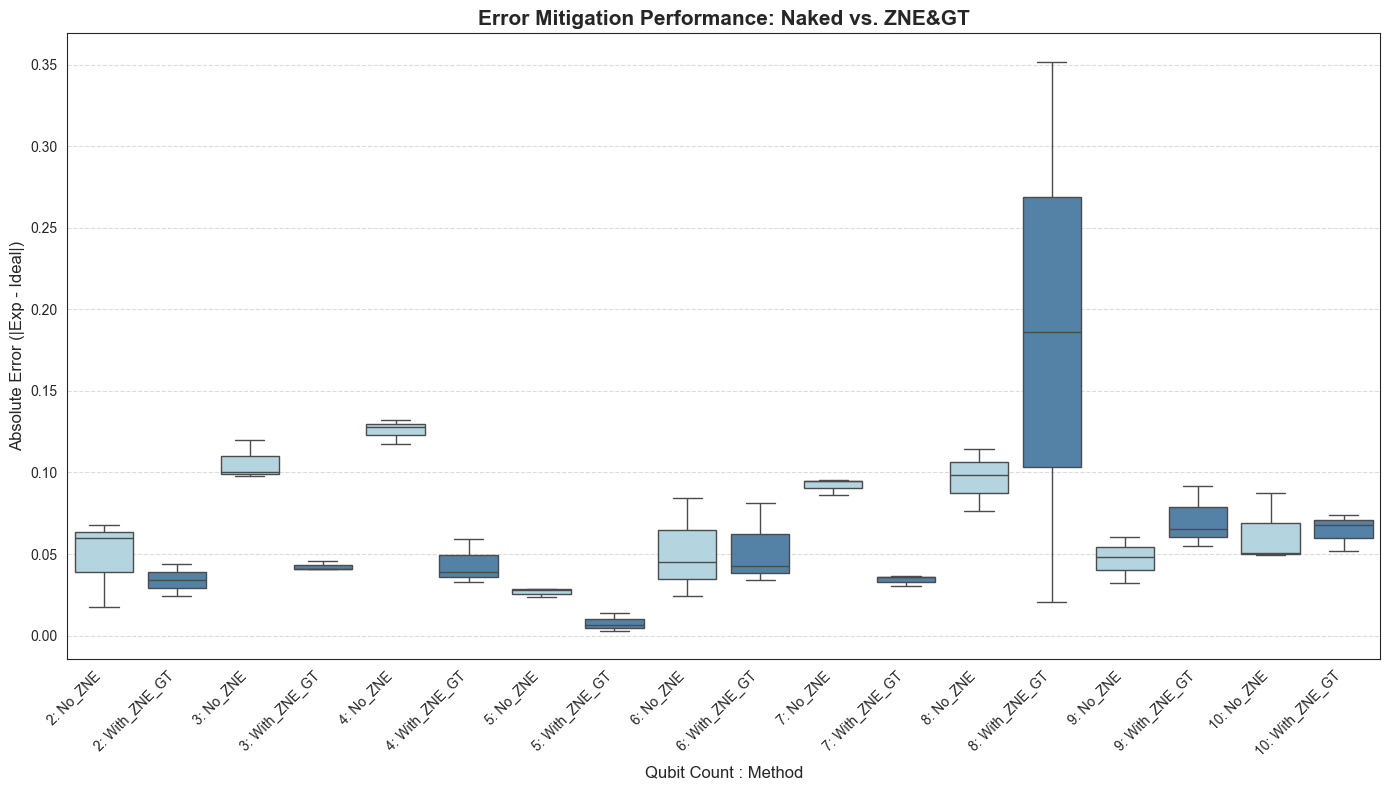

In [34]:
# 1. Data Preparation
# Create a combined label column: e.g., "3: No_ZNE", "3: With_ZNE"
df["Label"] = df["Qubits"].astype(str) + ": " + df["Mitigation"]

# Sort the dataframe so the X-axis is ordered logically (by Qubits, then by Mitigation)
# This ensures 2 qubits comes before 10 qubits, etc.
df = df.sort_values(by=["Qubits", "Mitigation"])

# 2. Setup Figure
plt.figure(figsize=(14, 8))
sns.set_style("white")  # Cleaner background like the template

# 3. Define Colors and Palette Logic
# Mapping your specific categories to the template's colors
# No_ZNE -> Light Blue (Baseline), With_ZNE -> Steel Blue (Mitigated)
color_map = {"No_ZNE": "#ADD8E6", "With_ZNE_GT": "#4682B4"}

unique_labels = df["Label"].unique()
# This list comprehension ensures the colors match the sorted order of the labels
palette_list = [color_map[label.split(": ")[1]] for label in unique_labels]

# 4. Create the Box Plot
sns.boxplot(
    data=df,
    x="Label",
    y="Abs_Error",
    hue="Label",  # Assign hue to Label to apply the palette
    palette=palette_list,
    dodge=False,  # Prevents grouping/shifting
    legend=False,  # Legend is redundant because x-axis labels explain it
    fliersize=3,  # Keep outlier dots small
)

# 5. Titles and Labels
plt.title("Error Mitigation Performance: Naked vs. ZNE&GT", fontsize=15, fontweight="bold")
plt.xlabel("Qubit Count : Method", fontsize=12)
plt.ylabel("Absolute Error (|Exp - Ideal|)", fontsize=12)

# 6. Adjust Axes and Grid (Matching the template style)
# Dynamic Y-limits with a small buffer
min_y = df["Abs_Error"].min()
max_y = df["Abs_Error"].max()
# Add 5% buffer to top and bottom
buffer = (max_y - min_y) * 0.05
plt.ylim(min_y - buffer, max_y + buffer)

# Grid only on Y-axis
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-labels for readability
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig("zne_comparison_flat.png", dpi=300)
plt.show()

In [35]:
# 1. Group by Qubits and Mitigation to get the MEAN Absolute Error across iterations
df_avg = df.groupby(["Qubits", "Mitigation"])["Abs_Error"].mean().unstack()

# 2. Calculate "Improvement" (Positive means ZNE reduced the error)
df_avg["Improvement"] = df_avg["No_ZNE"] - df_avg["With_ZNE_GT"]

In [36]:
# 1. Group by Qubits and Mitigation to get the MEAN Absolute Error across iterations
df_avg = df.groupby(["Qubits", "Mitigation"])["Abs_Error"].mean().unstack()

# 2. Calculate "Improvement" (Positive means ZNE reduced the error)
df_avg["Improvement"] = df_avg["No_ZNE"] - df_avg["With_ZNE_GT"]

# 3. Map your Custom Metrics
df_avg["H_ZNE"] = df.groupby("Qubits")["ZNE_Heuristic"].first()

# Reset index so 'Qubits' becomes a regular column for plotting
df_analysis = df_avg.reset_index()

# Check the data
print(df_analysis[["Qubits", "Improvement", "H_ZNE"]])

Mitigation  Qubits  Improvement     H_ZNE
0                2     0.014323  0.010451
1                3     0.063294  0.086869
2                4     0.082039  0.183083
3                5     0.019104  0.251335
4                6    -0.001500  0.368523
5                7     0.057976  0.425107
6                8    -0.089831  0.786534
7                9    -0.023872  1.288956
8               10    -0.002046  2.522828


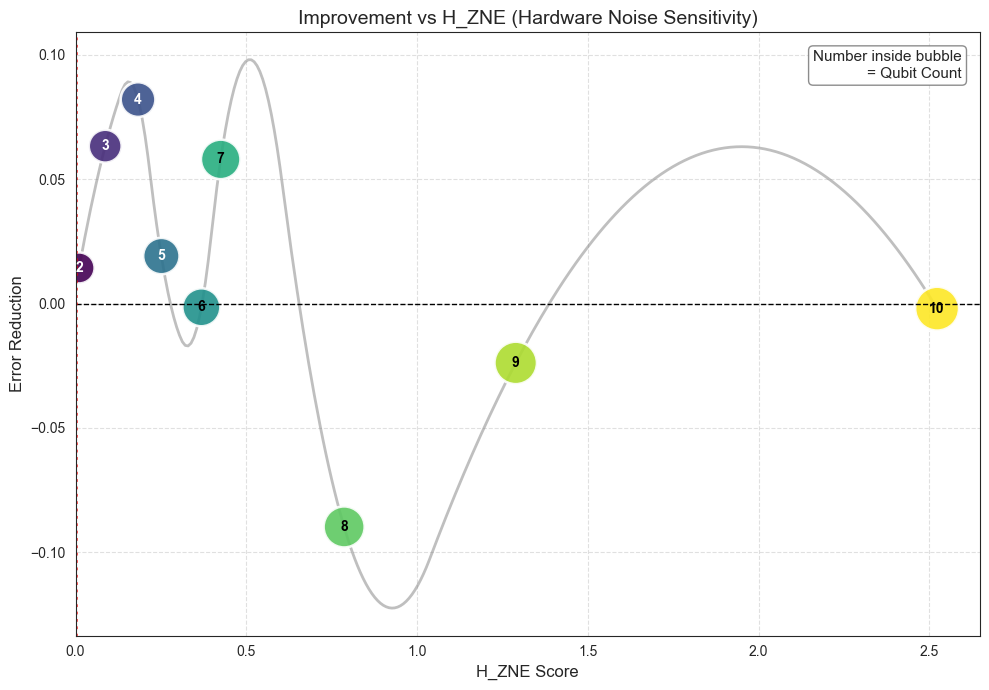

In [37]:
# Setup the figure (Single plot)
fig, ax = plt.subplots(figsize=(10, 7))
sns.set_style("whitegrid")


# Function to generate smooth curve data (From Template)
def get_smooth_curve(x_data, y_data, k=2, n_points=300):
    # Sort data to prevent spline errors
    sorted_indices = np.argsort(x_data)
    x_sorted = x_data.iloc[sorted_indices]
    y_sorted = y_data.iloc[sorted_indices]

    # Handle duplicates (spline requires unique x)
    x_unique, unique_indices = np.unique(x_sorted, return_index=True)
    y_unique = y_sorted.iloc[unique_indices]

    if len(x_unique) < k + 1:
        return x_unique, y_unique

    x_new = np.linspace(x_unique.min(), x_unique.max(), n_points)
    try:
        spl = make_interp_spline(x_unique, y_unique, k=k)
        y_smooth = spl(x_new)
        return x_new, y_smooth
    except Exception:
        return x_unique, y_unique


# --- PLOT: Improvement vs H_ZNE ---

# 1. Add SMOOTH connecting line
df_sorted = df_analysis.sort_values("H_ZNE")
x_smooth, y_smooth = get_smooth_curve(df_sorted["H_ZNE"], df_sorted["Improvement"])

ax.plot(x_smooth, y_smooth, color="gray", linewidth=2, alpha=0.5, zorder=1)

# 2. Scatter Plot
# Increased sizes to ensure text fits inside the bubbles
sns.scatterplot(
    data=df_analysis,
    x="H_ZNE",
    y="Improvement",
    hue="Qubits",
    palette="viridis",
    size="Qubits",
    sizes=(500, 1000),  # Large bubbles to accommodate text
    ax=ax,
    legend=False,
    zorder=2,
    alpha=0.9,
)

# 3. Add Qubit numbers inside the bubbles
# We iterate through the dataframe to place text at each x,y coordinate
for i in range(df_analysis.shape[0]):
    x_pos = df_analysis["H_ZNE"].iloc[i]
    y_pos = df_analysis["Improvement"].iloc[i]
    qubit_val = int(df_analysis["Qubits"].iloc[i])

    # Calculate text color based on qubit value (lighter for dark bubbles, darker for light bubbles)
    # Assuming Viridis: Low=Purple(Dark), High=Yellow(Light)
    text_color = "white" if qubit_val < df_analysis["Qubits"].median() else "black"

    ax.text(
        x_pos,
        y_pos,
        str(qubit_val),
        horizontalalignment="center",
        verticalalignment="center",
        size="medium",
        color=text_color,
        weight="bold",
    )

ax.text(
    0.98,
    0.97,  # x, y coordinates (relative to axes, 0-1)
    "Number inside bubble\n= Qubit Count",
    transform=ax.transAxes,  # Use axes coordinates so it stays in the corner
    fontsize=11,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9, edgecolor="gray"),
)

# 4. Reference lines and Labels
ax.set_title("Improvement vs H_ZNE (Hardware Noise Sensitivity)", fontsize=14)
ax.set_xlabel("H_ZNE Score", fontsize=12)
ax.set_ylabel("Error Reduction", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.6)

# Logic specific to H_ZNE plot (highlighting 0 axis)
ax.axhline(0, color="black", linewidth=1, linestyle="--")
ax.axvline(x=0, color="red", linestyle=":", linewidth=2, alpha=0.7)
ax.set_xlim(left=0)

plt.tight_layout()
plt.show()